<a href="https://colab.research.google.com/github/GabyA1999/GabyA1999.github.io/blob/master/Arredondo_CBOW_and_DAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
np.random.seed(0)


import torch 
torch.manual_seed(0)
from torch import nn


import torchtext

from collections import defaultdict
import time

import matplotlib.pyplot as plt
import pandas as pd


# Just to make the plots look nice.
%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

In [ ]:
files = './olid-training-v1.0.tsv'

In [ ]:
class CBoWTextClassifier(nn.Module):
    
    def __init__(self, text_field, class_field, emb_dim, dropout=0.5):
        super().__init__()        
        voc_size = len(text_field.vocab)
        n_classes = len(class_field.vocab)  

        # Embedding layer: we specify the vocabulary size and embedding dimensionality.        
        self.embedding = nn.Embedding(voc_size, emb_dim)

        # A linear output layer.
        self.top_layer = nn.Linear(emb_dim, n_classes)

        # A dropout layer to regularize the model.
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, docs):
        # The words in the documents are encoded as integers. The shape of the documents
        # tensor is (max_len, n_docs), where n_docs is the number of documents in this batch,
        # and max_len is the maximal length of a document in the batch.

        # First look up the embeddings for all the words in the documents.
        # The shape is now (max_len, n_docs, emb_dim).
        embedded = self.embedding(docs)

        # Compute the mean of word embeddings over the documents.
        # The shape is now (n_docs, emb_dim)
        cbow = embedded.mean(dim=0)

        # Apply the dropout layer. (This is only used during training, not during testing.)
        cbow_drop = self.dropout(cbow)

        # Finally, compute the output scores.
        scores = self.top_layer(cbow_drop)

        return scores

DAN MODEL
Hidden Layer ->

In [ ]:
class CBoWTextClassifier2(torch.nn.Module):
    
    def __init__(self, text_field, class_field, emb_dim, n_hidden=10, dropout=0.5):
        super().__init__()        
        voc_size = len(text_field.vocab)
        n_classes = len(class_field.vocab)       
        self.embedding = nn.Embedding(voc_size, emb_dim)
        self.hidden_layer = nn.Linear(emb_dim, n_hidden)
        self.top_layer = nn.Linear(n_hidden, n_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, texts):
        embedded = self.embedding(texts)
        cbow = embedded.mean(dim=0)
        cbow_drop = self.dropout(cbow)
        hidden = torch.relu(self.hidden_layer(cbow_drop))
        scores = self.top_layer(hidden)
        return scores 

Training text classifier

In [ ]:
def read_data(corpus_file, datafields):
    #with open(corpus_file, encoding='utf-8') as f:
    df = pd.read_csv(files, sep='\t')
    examples = []
    for ind, row in df.iterrows():
        tweets = row[1]
        offense_label = row[2]
        examples.append(torchtext.data.Example.fromlist([tweets, offense_label], datafields))
    return torchtext.data.Dataset(examples, datafields)

In [ ]:
def evaluate_validation(scores, loss_function, gold):
    guesses = scores.argmax(dim=1)
    n_correct = (guesses == gold).sum().item()
    return n_correct, loss_function(scores, gold).item()

In [ ]:
def main():
    
    # We first declare the fields of the dataset: one field for the text, and one for the output label.
    # For the text field, we also provide a tokenizer.
    # In this case, we can use a simple tokenizer since the text is already tokenized in the file.
    TEXT = torchtext.data.Field(sequential=True, tokenize=lambda x: x.split())
    LABEL = torchtext.data.LabelField(is_target=True)
    datafields = [('text', TEXT), ('label', LABEL)]

    # By default, we'll do sentiment classification using the Amazon dataset.
    # If you want to use the AG corpus instead of the Amazon dataset, change this flag.

    data = read_data(files, datafields)
    train, valid = data.split([0.85, 0.15])

    # Build vocabularies from the dataset.
    TEXT.build_vocab(train, max_size=10000)
    LABEL.build_vocab(train)
    
    # Declare the model. We'll use the shallow CBoW classifier or the one that has one hidden layer.
    model = CBoWTextClassifier(TEXT, LABEL, emb_dim=16)   
    #model = CBoWTextClassifier2(TEXT, LABEL, emb_dim=16)
    
    # Put the model on the device.
    device = 'cuda'
    model.to(device)
    
    # The BucketIterator groups sentences of similar lengths into "buckets", which reduces the need
    # for padding when we create minibatches.
    # See here: https://pytorch.org/text/data.html#torchtext.data.BucketIterator
    train_iterator = torchtext.data.BucketIterator(
        train,
        device=device,
        batch_size=128,
        sort_key=lambda x: len(x.text),
        repeat=False,
        train=True)
    
    valid_iterator = torchtext.data.Iterator(
        valid,
        device=device,
        batch_size=128,
        repeat=False,
        train=False,
        sort=False)

    # Cross-entropy loss as usual, since we have a classification problem.
    loss_function = torch.nn.CrossEntropyLoss()
    
    # Adam optimizer. We can try to tune the learning rate to get a fast convergence while avoiding instability.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # To speed up training, we'll put all the batches onto the GPU. This will avoid repeating
    # the preprocessing of the batches as well as the GPU communication overhead.
    # We can do this because the dataset is not that big so that it fits in the GPU memory.
    # Torchtext will handle all administration: mapping text to integers and putting everything into tensors.
    train_batches = list(train_iterator)
    valid_batches = list(valid_iterator)

    # We'll keep track of some indicators and plot them in the end.
    history = defaultdict(list)
    
    #looping through training 
    for i in range(200): 
        
        t0 = time.time()
        
        loss_sum = 0
        n_batches = 0

        # Calling model.train() will enable the dropout layers.
        model.train()
        
        # We iterate through the batches created by torchtext.
        # For each batch, we can access the text part and the output label part separately.
        for batch in train_batches:
            
            # Compute the output scores.
            scores = model(batch.text)
            # Then the loss function.
            loss = loss_function(scores, batch.label)

            # Compute the gradient with respect to the loss, and update the parameters of the model.
            optimizer.zero_grad()            
            loss.backward()
            optimizer.step()
    
            loss_sum += loss.item()
            n_batches += 1
        
        train_loss = loss_sum / n_batches
        history['train_loss'].append(train_loss)
        
        # After each training epoch, we'll compute the loss and accuracy on the validation set.
        n_correct = 0
        n_valid = len(valid)
        loss_sum = 0
        n_batches = 0

        # Calling model.train() will disable the dropout layers.
        model.eval()
        
        for batch in valid_batches:
            scores = model(batch.text)
            n_corr_batch, loss_batch = evaluate_validation(scores, loss_function, batch.label)
            loss_sum += loss_batch
            n_correct += n_corr_batch
            n_batches += 1
        val_acc = n_correct / n_valid
        val_loss = loss_sum / n_batches

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)        
        
        t1 = time.time()

        if (i+1) % 10 == 0:
            
            print(f'Epoch {i+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}, val acc: {val_acc:.4f}, time = {t1-t0:.4f}')

    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.plot(history['val_acc'])
    plt.legend(['training loss', 'validation loss', 'validation accuracy'])

Epoch 10: train loss = 0.6335, val loss = 0.6348, val acc: 0.6667, time = 0.1696
Epoch 20: train loss = 0.6239, val loss = 0.6291, val acc: 0.6667, time = 0.1700
Epoch 30: train loss = 0.6070, val loss = 0.6203, val acc: 0.6722, time = 0.1746
Epoch 40: train loss = 0.5763, val loss = 0.6064, val acc: 0.6777, time = 0.1694
Epoch 50: train loss = 0.5413, val loss = 0.5915, val acc: 0.6898, time = 0.1783
Epoch 60: train loss = 0.4963, val loss = 0.5800, val acc: 0.7100, time = 0.1765
Epoch 70: train loss = 0.4509, val loss = 0.5767, val acc: 0.7115, time = 0.1781
Epoch 80: train loss = 0.4139, val loss = 0.5827, val acc: 0.7185, time = 0.1699
Epoch 90: train loss = 0.3785, val loss = 0.5965, val acc: 0.7155, time = 0.1684
Epoch 100: train loss = 0.3537, val loss = 0.6172, val acc: 0.7185, time = 0.1777
Epoch 110: train loss = 0.3242, val loss = 0.6435, val acc: 0.7205, time = 0.1727
Epoch 120: train loss = 0.3046, val loss = 0.6749, val acc: 0.7205, time = 0.1698
Epoch 130: train loss = 0

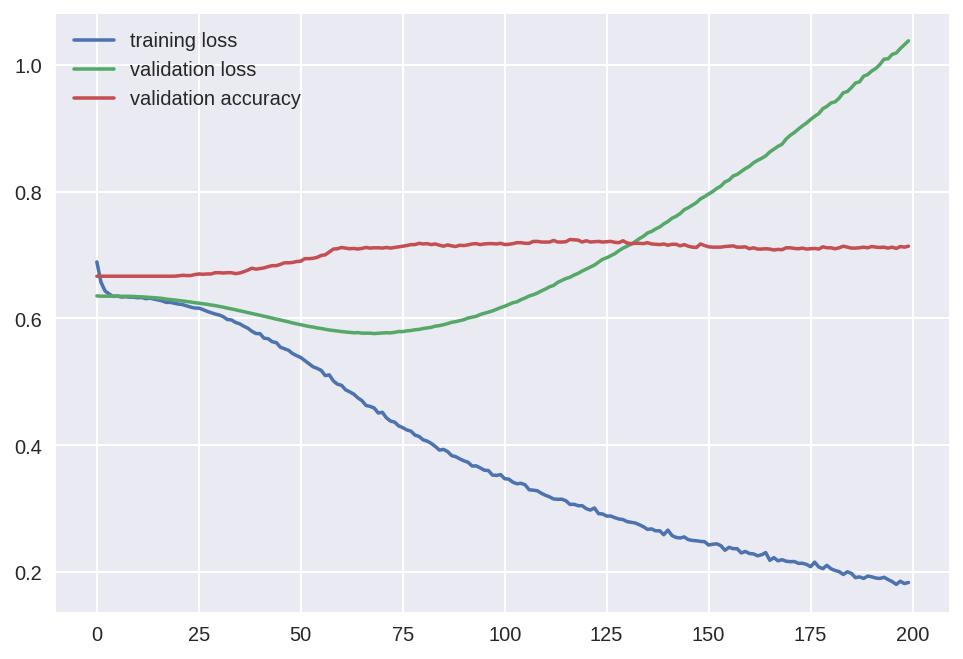

In [ ]:
#main()

text_file = open("cbow_and_dan_out.txt", "a")
text_file.write(str(main()))    
text_file.close()



In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("olid-training-v1.0.tsv", sep="\t")

In [ ]:
df.keys()

Index(['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c'], dtype='object')

In [ ]:
for ind, row in df.iterrows():
  row = row
  

In [ ]:
row

id                                                       46552
tweet        #Spanishrevenge vs. #justice #HumanRights and ...
subtask_a                                                  NOT
subtask_b                                                  NaN
subtask_c                                                  NaN
Name: 13239, dtype: object

In [ ]:
row['tweet'], row['subtask_a'] 

('#Spanishrevenge vs. #justice #HumanRights and #FreedomOfExpression #Spain is a  #fakedemocracy @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER #cddr #shameonSpain #WakeupEurope @USER URL',
 'NOT')

In [ ]:
df.keys()

Index(['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c'], dtype='object')

In [ ]:
df['tweet']

0        @USER She should ask a few native Americans wh...
1        @USER @USER Go home you’re drunk!!! @USER #MAG...
2        Amazon is investigating Chinese employees who ...
3        @USER Someone should'veTaken" this piece of sh...
4        @USER @USER Obama wanted liberals &amp; illega...
                               ...                        
13235    @USER Sometimes I get strong vibes from people...
13236    Benidorm ✅  Creamfields ✅  Maga ✅   Not too sh...
13237    @USER And why report this garbage.  We don't g...
13238                                          @USER Pussy
13239    #Spanishrevenge vs. #justice #HumanRights and ...
Name: tweet, Length: 13240, dtype: object

In [ ]:
df.sample(5)

,id,tweet,subtask_a,subtask_b,subtask_c
12823,16623,@USER Good! #Antifa is violent fascism.,NOT,NaN,NaN
12290,94731,@USER It has been being de-created slowly and ...,NOT,NaN,NaN
8474,69998,* Christian Kabasele reveals the secrets behin...,NOT,NaN,NaN
4676,43647,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT,NaN,NaN
397,58548,@USER @USER Wonder if he apologized to Diamond...,OFF,TIN,IND


In [ ]:
sum(df['id'])
sum(df'')

726634584

In [ ]:
[sum(df[key]) for key in df.keys()]

TypeError: ignored

In [ ]:
df['tweet'].map(lambda x: x.replace("@USER", ''))

0         She should ask a few native Americans what th...
1          Go home you’re drunk!!!  #MAGA #Trump2020 👊🇺...
2        Amazon is investigating Chinese employees who ...
3         Someone should'veTaken" this piece of shit to...
4          Obama wanted liberals &amp; illegals to move...
                               ...                        
13235     Sometimes I get strong vibes from people and ...
13236    Benidorm ✅  Creamfields ✅  Maga ✅   Not too sh...
13237     And why report this garbage.  We don't give a...
13238                                                Pussy
13239    #Spanishrevenge vs. #justice #HumanRights and ...
Name: tweet, Length: 13240, dtype: object

In [ ]:
df['subtask_a'].describe()

count     13240
unique        2
top         NOT
freq       8840
Name: subtask_a, dtype: object